## Import the required packages 

In [232]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.utils import resample
%matplotlib inline 

## Import the data 

In [79]:
ceramic_df = pd.read_csv("Chemical Composion of Ceramic.csv")

ceramic_df.head()

,Ceramic Name,Part,Na2O,MgO,Al2O3,SiO2,K2O,CaO,TiO2,Fe2O3,MnO,CuO,ZnO,PbO2,Rb2O,SrO,Y2O3,ZrO2,P2O5
0,FLQ-1-b,Body,0.62,0.38,19.61,71.99,4.84,0.31,0.07,1.18,630,10,70,10,430,0,40,80,90
1,FLQ-2-b,Body,0.57,0.47,21.19,70.09,4.98,0.49,0.09,1.12,380,20,80,40,430,-10,40,100,110
2,FLQ-3-b,Body,0.49,0.19,18.60,74.70,3.47,0.43,0.06,1.07,420,20,50,50,380,40,40,80,200
3,FLQ-4-b,Body,0.89,0.30,18.01,74.19,4.01,0.27,0.09,1.23,460,20,70,60,380,10,40,70,210
4,FLQ-5-b,Body,0.03,0.36,18.41,73.99,4.33,0.65,0.05,1.19,380,40,90,40,360,10,30,80,150


In [80]:
ceramic_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 88 entries, 0 to 87
Data columns (total 19 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Ceramic Name  88 non-null     object 
 1   Part          88 non-null     object 
 2   Na2O          88 non-null     float64
 3   MgO           88 non-null     float64
 4   Al2O3         88 non-null     float64
 5   SiO2          88 non-null     float64
 6   K2O           88 non-null     float64
 7   CaO           88 non-null     float64
 8   TiO2          88 non-null     float64
 9   Fe2O3         88 non-null     float64
 10  MnO           88 non-null     int64  
 11  CuO           88 non-null     int64  
 12  ZnO           88 non-null     int64  
 13  PbO2          88 non-null     int64  
 14  Rb2O          88 non-null     int64  
 15  SrO           88 non-null     int64  
 16  Y2O3          88 non-null     int64  
 17  ZrO2          88 non-null     int64  
 18  P2O5          88 non-null     in

## Remove null values and negative values as we cant get a negative parts per million 

In [81]:
#no null values to worry about
ceramic_df[ceramic_df.isnull().any(axis=1)]

,Ceramic Name,Part,Na2O,MgO,Al2O3,SiO2,K2O,CaO,TiO2,Fe2O3,MnO,CuO,ZnO,PbO2,Rb2O,SrO,Y2O3,ZrO2,P2O5


In [82]:
#Check if any axis is less than 0 
ceramic_val_df = ceramic_df[ceramic_df.select_dtypes(include=['int64', 'float64']).columns]
ceramic_val_df.any(axis = 1).any()

True

In [84]:
#Replace values less than 0 with 0 
ceramic_df[ceramic_df.select_dtypes(include=['int64', 'float64']).columns] = ceramic_val_df.where(ceramic_val_df > 0 , 0) 

## Explore interdependencies in the chemical ratios 

In [32]:
#Unique ceramic name to make sure no duplicate entries 
len(ceramic_df['Ceramic Name'].unique())

88

In [33]:
# body and glaze tested for each so each can be seperatly evaluted to see if body and glaze overlap 
ceramic_df.groupby('Part')['Ceramic Name'].nunique()

Part
Body     44
Glaze    44
Name: Ceramic Name, dtype: int64

In [190]:
# Can use as an effective test and control to see if period align 
ceramic_body_df = ceramic_df[ceramic_df['Part'] == "Body"]
ceramic_glaze_df = ceramic_df[ceramic_df['Part'] == "Glaze"]

 Check the Chemical distribuition for each to see if there are any outliers 

In [192]:
# Create plot to show distibution and outliers to look into for each data frame
def plot_histograms(df):

    numeric_columns = df.select_dtypes(include=['int64', 'float64']).columns
    num_columns = len(numeric_columns)

    fig, axes = plt.subplots(num_columns, 1, figsize=(12, 30)) 

    for i, column in enumerate(numeric_columns):
        df[column].hist(ax=axes[i], edgecolor='black', grid=False)
        axes[i].set_title(f'Histogram of {column}')
        axes[i].set_xlabel(column)
        axes[i].set_ylabel('Frequency')

    plt.tight_layout()
    plt.show()


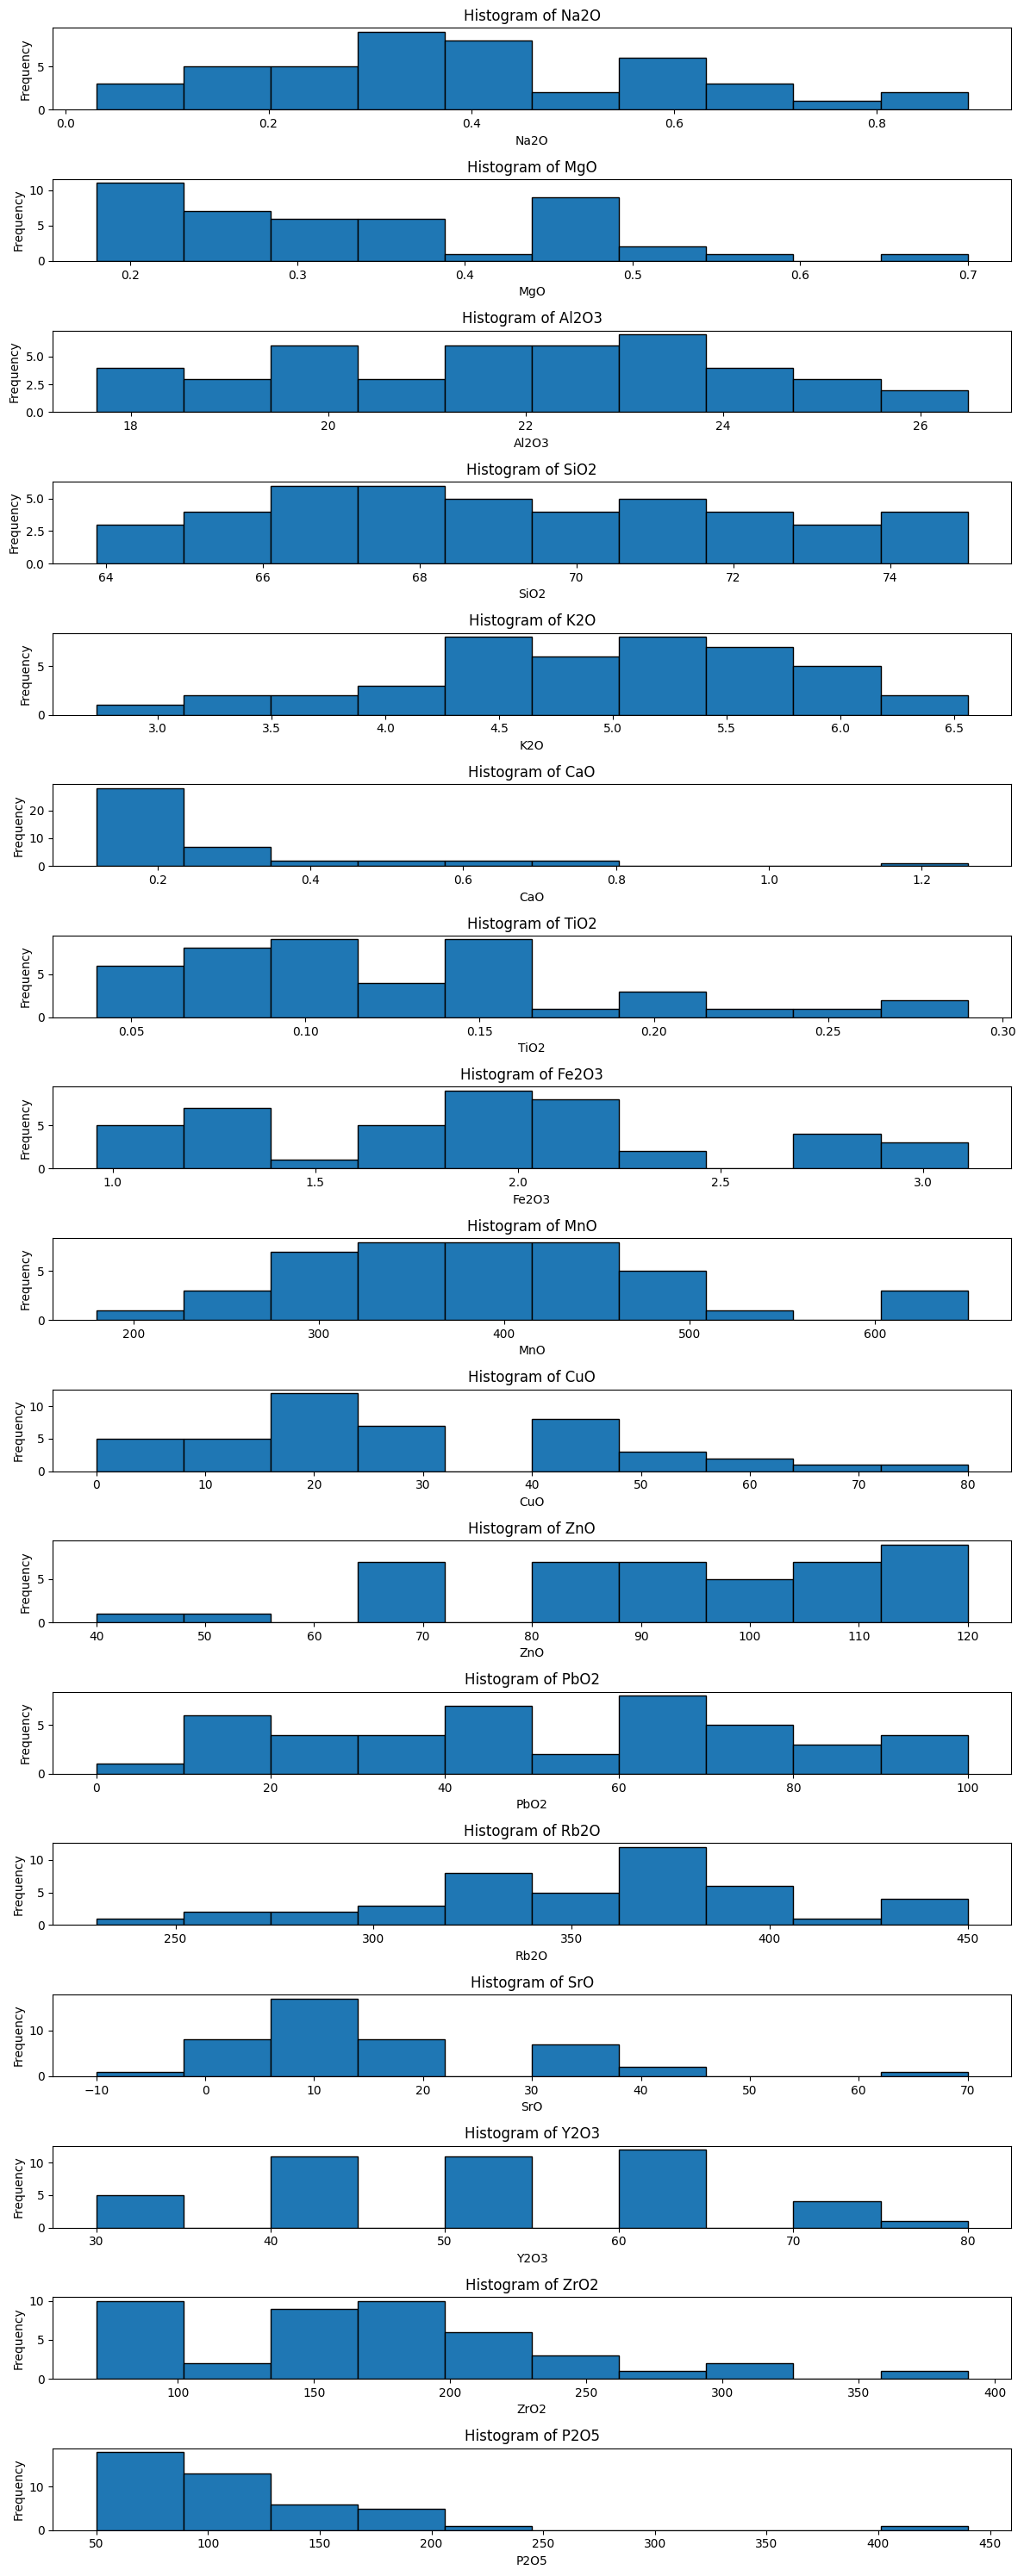

In [36]:
plot_histograms(ceramic_body_df)

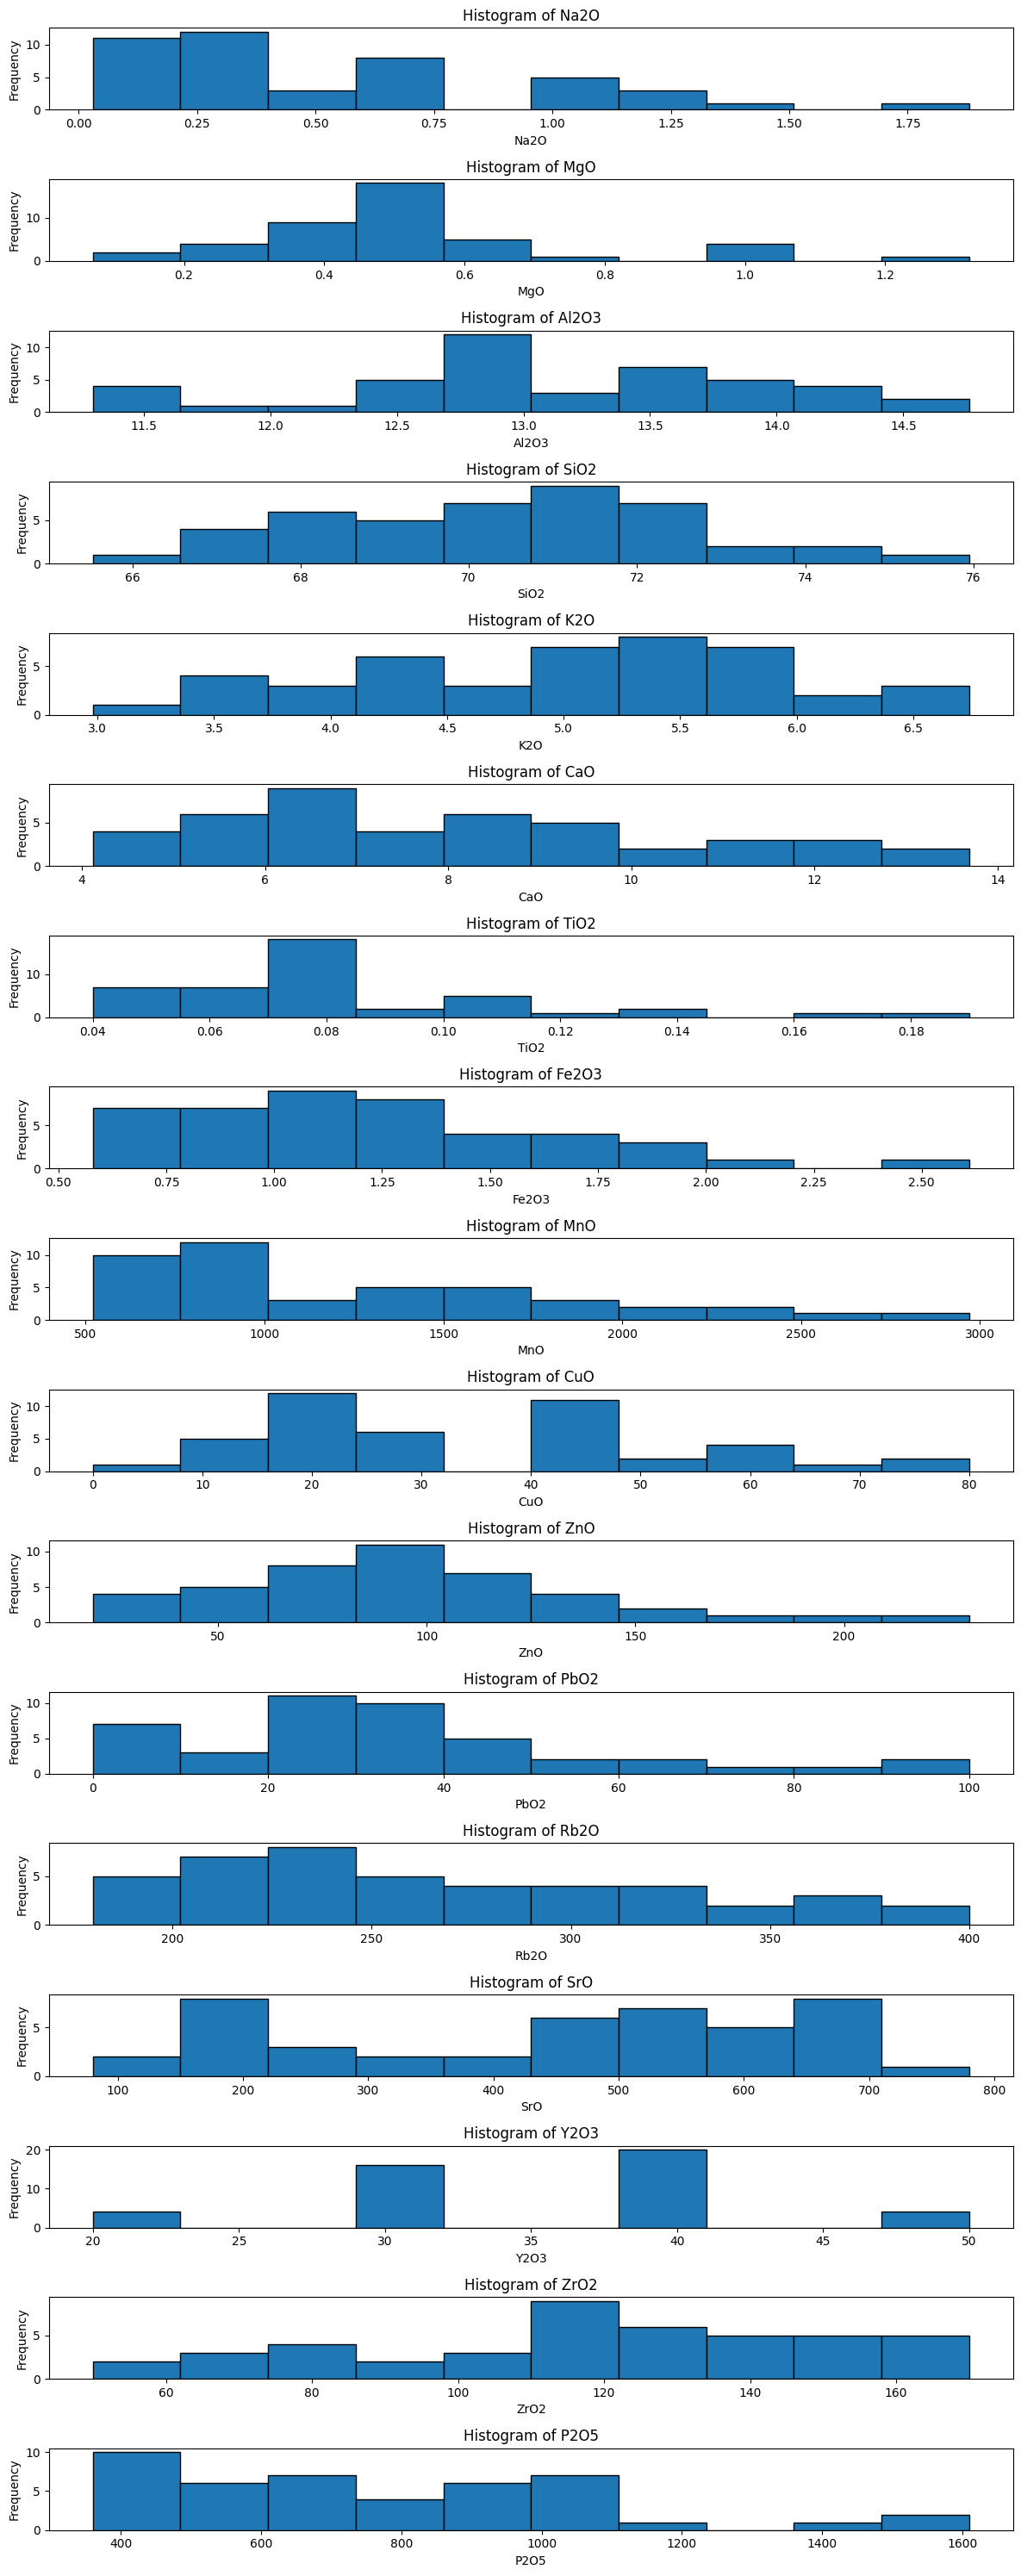

In [37]:
plot_histograms(ceramic_glaze_df)

<Axes: >

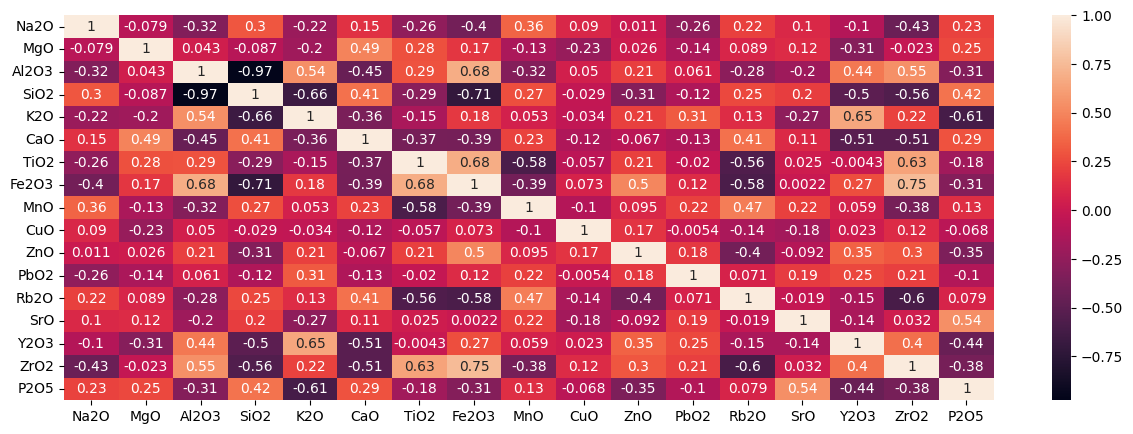

In [93]:
#Create function to show the heat map of correlations to investigate 
plt.figure(figsize=(15, 5))
plt.title("Correlations ")
sns.heatmap(ceramic_body_df[ceramic_body_df.select_dtypes(include=['int64', 'float64']).columns].corr(),annot= True)


<Axes: >

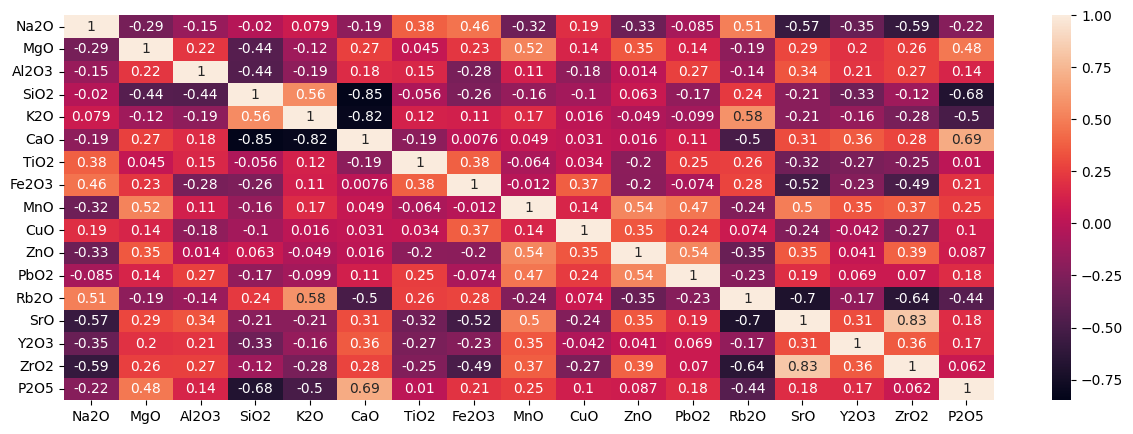

In [94]:
#Create function to show the heat map of correlations to investigate 
plt.figure(figsize=(15, 5))
sns.heatmap(ceramic_glaze_df[ceramic_glaze_df.select_dtypes(include=['int64', 'float64']).columns].corr(),annot= True)

In [ ]:
#########################
###     Notes       #####
#########################
# Will need to use factor anlysis to remove high multicoliniarity factors 
# This will be done serperatly for glazing and the body as each have different multicollinearity
# Most data is evenly/normally distributed with a few outliers that will need to be accounted for in the pipline

## Create a pipline to work on both glaze and body data 

In [195]:
# create function to see the number of columns that are outside a given standerd deviation
def std_dev_spead(df,num_std):
    df_val = df[df.select_dtypes(include=['int64', 'float64']).columns]

    mean = df_val.mean()
    std_dev = df_val.std()

    mod_val_df = abs((df_val - mean) / std_dev)

    # Get the ratio of points above the given standerd deviations 
    return mod_val_df[mod_val_df > num_std].count().sum()/( len(mod_val_df) * len(mod_val_df.iloc[0]))

In [196]:
std_dev_spead(ceramic_glaze_df,2)

0.0374331550802139

In [197]:
std_dev_spead(ceramic_body_df,2)

0.03208556149732621

In [ ]:
# Due to the small data set menaing values cannot be dropped, we will change all values to 2 standerd deviations away that are above this threshold.
# We will put this in the pipline

In [199]:
def anom_standerd(df):
    df_val = df[df.select_dtypes(include=['int64', 'float64']).columns]

    mean = df_val.mean()
    std_dev = df_val.std()

    #greater than 2 std out then make std
    df[df.select_dtypes(include=['int64', 'float64']).columns] = df_val.where((df_val - mean/std_dev) > 2 , 2 * std_dev) 
    df[df.select_dtypes(include=['int64', 'float64']).columns] = df_val.where((df_val - mean/std_dev) < 2 , - 2 * std_dev) 

    return df 

In [202]:
ceramic_glaze_df.head()

,Ceramic Name,Part,Na2O,MgO,Al2O3,SiO2,K2O,CaO,TiO2,Fe2O3,MnO,CuO,ZnO,PbO2,Rb2O,SrO,Y2O3,ZrO2,P2O5
44,FLQ-1-g,Glaze,0.97,0.07,11.42,74.41,5.70,5.34,0.05,1.04,550,20,60,20,310,150,20,50,390
45,FLQ-2-g,Glaze,1.46,0.47,12.96,68.79,4.85,8.88,0.11,1.49,950,30,40,0,350,250,30,60,840
46,FLQ-3-g,Glaze,1.05,0.23,13.64,69.90,4.46,8.43,0.07,1.22,590,20,90,40,370,90,40,80,460
47,FLQ-4-g,Glaze,0.14,0.41,12.42,67.24,4.29,12.86,0.06,1.58,960,80,70,40,330,160,40,70,1000
48,FLQ-5-g,Glaze,0.37,1.03,13.15,68.98,5.58,7.91,0.08,1.90,800,60,120,0,320,80,40,80,1080


Create the pipline

In [237]:
# Due to the small number of values over and under by 2 std, we will restirct vales to this to avoid outliers 
#Will need to be changed to a clas for the pipline 
class AnomStandard():
    def __init__(self):
        self.mean = None
        self.std_dev = None

    def fit(self, X, y=None):
        df_val = X[X.select_dtypes(include=['int64', 'float64']).columns]
        self.mean = df_val.mean()
        self.std_dev = df_val.std()
        return self

    def transform(self, X):
        df_val = X.select_dtypes(include=['int64', 'float64'])
        for col in df_val.columns:
            X.loc[:, col] = df_val[col].where((df_val[col] - self.mean[col])/self.std_dev[col] <= 2 , 2 * self.std_dev[col]) 
            X.loc[:, col] = df_val[col].where((df_val[col] - self.mean[col])/self.std_dev[col] >= -2 , -2 * self.std_dev[col]) 
        return X


def cluster_no_indentification(df, n_bootstrap=50):
    df_val = df[df.select_dtypes(include=['int64', 'float64']).columns]

    pipeline = Pipeline([
        ('custom', AnomStandard()),
        ('scaler', StandardScaler()),
        ('pca',  PCA(n_components  = 0.9)),
        ('kmeans', KMeans(n_init = 'auto'))  
    ])

    pipeline.fit_transform(df_val)

    sse = []
    for _ in range(n_bootstrap):
        # Create a bootstrap sample
        df_sample = resample(df_val)

        # Fit and transform the sample
        pipeline.fit_transform(df_sample)

        # Calculate SSE for different numbers of clusters
        sse_sample = []
        for k in range(1, 11):
            pipeline.set_params(kmeans__n_clusters=k)
            pipeline.fit(df_sample)
            sse_sample.append(pipeline.named_steps['kmeans'].inertia_)

        # Append the SSE for this sample to the list of all SSEs
        sse.append(sse_sample)

    # Calculate the mean SSE across all bootstrap samples for each number of clusters
    sse_mean = np.mean(sse, axis=0)

    plt.plot(range(1, 11), sse_mean)
    plt.xlabel('Number of clusters')
    plt.ylabel('SSE')
    plt.show()

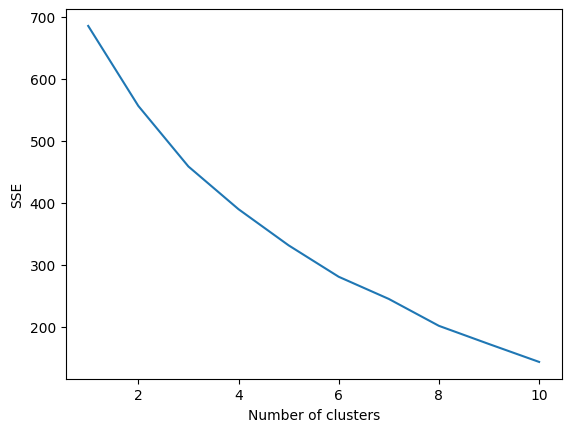

In [238]:
# 3 clusters seem to be the correct number for this 
cluster_no_indentification(ceramic_glaze_df)

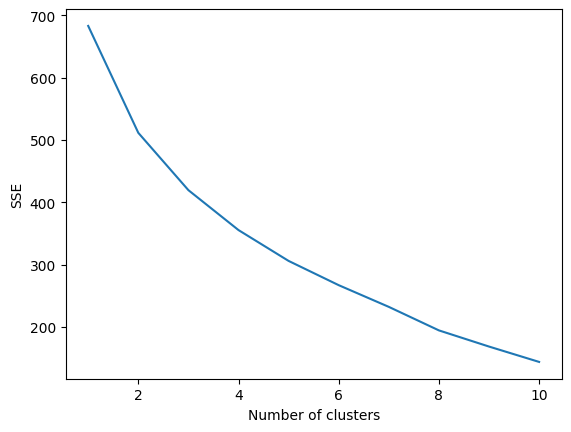

In [239]:
# We see a simlar number of clusters but this may be 3 or 4
cluster_no_indentification(ceramic_body_df)

## Check the overlap of clusters to compare groups 

In [248]:
def cluster_no_indentification(df, n_cluster = 3):
    df_val = df[df.select_dtypes(include=['int64', 'float64']).columns]

    pipeline = Pipeline([
        ('custom', AnomStandard()),
        ('scaler', StandardScaler()),
        ('pca',  PCA(n_components  = 0.9)),
        ('kmeans', KMeans(n_init = 'auto',n_clusters = n_cluster ))  
    ])

    pipeline.fit_transform(df_val)

    df['cluster'] = pipeline.named_steps['kmeans'].labels_ + 1

    return df 

In [261]:
ceramic_body_clust_df = cluster_no_indentification(ceramic_body_df,3)
ceramic_glaze_clust_df = cluster_no_indentification(ceramic_glaze_df,3)

C:\Users\benedict.grant\AppData\Local\Temp\ipykernel_13068\3328365205.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['cluster'] = pipeline.named_steps['kmeans'].labels_ + 1
C:\Users\benedict.grant\AppData\Local\Temp\ipykernel_13068\3328365205.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['cluster'] = pipeline.named_steps['kmeans'].labels_ + 1


In [262]:
#Find the overlap between each one of the groups 

,Ceramic Name,Part,Na2O,MgO,Al2O3,SiO2,K2O,CaO,TiO2,Fe2O3,MnO,CuO,ZnO,PbO2,Rb2O,SrO,Y2O3,ZrO2,P2O5,cluster
0,FLQ-1-b,Body,0.62,0.38,19.61,71.99,4.84,0.31,0.07,1.18,630,10,70,10,430,0,40,80,90,3
1,FLQ-2-b,Body,0.57,0.47,21.19,70.09,4.98,0.49,0.09,1.12,380,20,80,40,430,0,40,100,110,3
2,FLQ-3-b,Body,0.49,0.19,18.60,74.70,3.47,0.43,0.06,1.07,420,20,50,50,380,40,40,80,200,3
3,FLQ-4-b,Body,0.89,0.30,18.01,74.19,4.01,0.27,0.09,1.23,460,20,70,60,380,10,40,70,210,3
4,FLQ-5-b,Body,0.03,0.36,18.41,73.99,4.33,0.65,0.05,1.19,380,40,90,40,360,10,30,80,150,3
5,FLQ-6-b,Body,0.62,0.18,18.82,73.79,4.28,0.30,0.04,0.96,350,20,80,10,390,10,40,80,130,3
6,FLQ-7-b,Body,0.45,0.33,17.65,74.99,3.53,0.70,0.07,1.28,650,20,90,90,410,30,30,90,140,3
7,FLQ-8-b,Body,0.59,0.45,21.42,71.46,3.47,0.35,0.05,1.20,500,10,70,50,380,70,40,80,440,3
8,FLQ-9-b,Body,0.42,0.53,23.12,67.41,3.81,0.74,0.16,2.81,340,40,120,30,370,20,30,150,180,1
9,FLQ-10-b,Body,0.56,0.49,19.86,72.00,4.51,0.25,0.23,1.10,330,20,70,20,350,10,40,130,150,3


## Find the key factors that conrtibute to each cluster from the PCA 